# Intro to Deep Learning
#### Haider Al-Tahan

This is the practical component of this tutorial will focus on hands-on experience with Tensorflow/Pytorch. Topics will include:

1.   Introduction to Tensorflow and Pytorch. 
2.   Train and evaluate  of dense and convolutional neural networks for real problems.
3.   An open session for exploring and adapting existing NNs or for helping attendees build their own networks.

You can use [Google Colaboratory]('http://colab.research.google.com') notebook file which is a [Jupyter notebook]('https://jupyter.org/') with free limited access to a GPU. Jupyter notebooks allows python programs to run directly in the browser which can be great way to learn and use TensorFlow.

If you are using Google colab notebook and want to utilize the free GPU for training, do the following:

1. At the top-left of the of the menu bar, Select `Runtime` > `Change runtime type`. 
2. Click on `Hardware accelerator` > `GPU`.
3. At the top-right of the menu bar, select `CONNECT` to initialize your python interpreter.


# TensorFlow Installation
Note: you can also use this notebook locally on your machine. Just make sure that you have TensorFlow 2.0.
When installing TensorFlow on your local machine, you also need to make sure that you have the right CPU or GPU version depending your machine.
* If you have a GPU with CUDA and Cudnn or using google colab installed then you just do `pip install tensorflow-gpu==2.0.0` in your terminal.
* If you don't have CUDA and Cudnn installed but have a GPU then follow [these instructions]('https://www.tensorflow.org/install/gpu').
* Otherwise you can use your CPU and install TensorFlow by running `pip install tensorflow==2.0.0` in your terminal.

In [ ]:
# Without GPU
# !pip install tensorflow==2.0.0
# With GPU 
# !pip install tensorflow-gpu==2.0.0
# !pip install matplotlib
# If using colab
%tensorflow_version 2.x

TensorFlow 2.x selected.


# Imports

In [44]:
import torch # PyTorch
import tensorflow as tf # TensorFlow
from tensorflow import keras # Keras
import numpy as np # Numpy
from tqdm import tqdm
from sklearn.model_selection import train_test_split # Easy to use function to split my data
import matplotlib.pyplot as plt # Library for Visualization
from torchvision import datasets, transforms
import torch.nn.functional as F
from matplotlib.lines import Line2D
from tensorflow.keras import applications
print(tf.__version__)

2.7.0


# Neural Networks Basics

![alt text](https://miro.medium.com/max/465/1*fX2hHozXqOOnj_bMmQpMIg.jpeg)
[image source](https://becominghuman.ai/artificial-neuron-networks-basics-introduction-to-neural-networks-3082f1dcca8c)


## Temperature Conversion Problem

In [ ]:
def CtoF(c):
    return c * 1.8 + 32

### PyTorch

#### Constants

In [ ]:
BATCH_SIZE = 32
LEARNING_RATE = 0.1
EPOCHS = 100

#### Dataset

In [ ]:
# Celcius data ranging from 1 to 1000 
x_train = torch.tensor(range(0, 1000), dtype=torch.float32).view(-1, 1)
# Fahrenheit data converted using the above function
y_train = torch.tensor(list(map(CtoF, x_train)), dtype=torch.float32).view(-1, 1)

# Getting data ready for PyTorch
dataset = torch.utils.data.TensorDataset(x_train, y_train)
dataset = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)

#### Loss Function

In [ ]:
loss_fn = torch.nn.MSELoss()

#### Model

In [ ]:
model = torch.nn.Sequential(torch.nn.Linear(1,1, bias=True))

#### Optimizer

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

#### Training

In [ ]:
loss_history = []
for i in tqdm(range(EPOCHS)):
    mloss = []
    for X, y in dataset:
        optimizer.zero_grad()
        loss = loss_fn(model(X), y)
        loss.backward()
        optimizer.step()
        mloss.append(loss.item())
    loss_history.append(np.array(mloss).mean())

100%|██████████| 100/100 [00:01<00:00, 53.45it/s]


#### Performance

In [ ]:
for param in model.parameters():
  print(param.data)

tensor([[1.8088]])
tensor([26.0471])


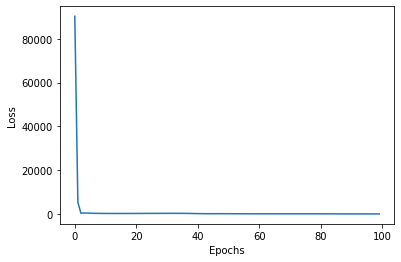

In [ ]:
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.plot(loss_history)

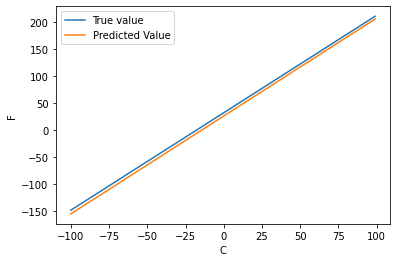

In [ ]:
xtest = torch.tensor(range(-100, 100), dtype=torch.float32).view(-1, 1)
ytest = torch.tensor(list(map(CtoF, xtest)), dtype=torch.float32).view(-1, 1)

y_pred = model(xtest)
plt.xlabel('C')
plt.ylabel("F")
plt.plot(xtest.numpy(), ytest.numpy())
plt.plot(xtest.numpy(), y_pred.detach().numpy())
plt.legend(['True value', 'Predicted Value'])

### TensorFlow

#### Dataset

In [ ]:
# Celcius data ranging from 1 to 1000 
x_train = np.array(list(range(1, 1000))).reshape((-1, 1))
# Fahrenheit data converted using the above function
y_train = np.array(list(map(CtoF, x_train))).reshape((-1, 1))

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BATCH_SIZE).batch(BATCH_SIZE)

#### Loss Function

In [ ]:
loss_fn = tf.keras.losses.MSE

#### Model

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_shape=[1]))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


#### Optimizer

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

#### Training Step

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

@tf.function
def train_step(X, y):
  with tf.GradientTape() as tape:
    predictions = model(X)
    loss = loss_fn(y, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)

#### Training

100%|██████████| 100/100 [00:03<00:00, 25.45it/s]


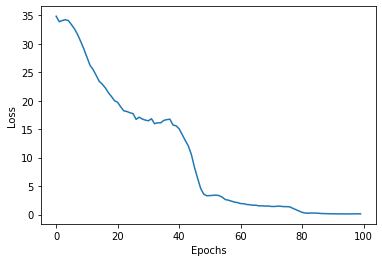

In [ ]:
loss_history = []
for epoch in tqdm(range(EPOCHS)):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()

  for X, y in dataset:
    train_step(X, y)

  loss_history.append(train_loss.result())
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.plot(loss_history)

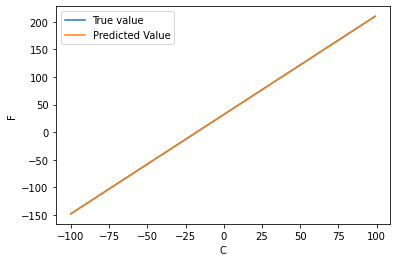

In [ ]:
xtest = np.array(list(range(-100,100))).reshape((-1, 1))
ytest = np.array(list(map(CtoF, xtest))).reshape((-1, 1))

y_pred = model(xtest)
plt.xlabel('C')
plt.ylabel("F")
plt.plot(xtest, list(ytest))
plt.plot(xtest, y_pred)
plt.legend(['True value', 'Predicted Value'])

# Images as Input

## Datasets


For the first example we will use varous dataset. Keras provide us with basic image datasets that we could load with ease. Here is few that we are going to test:

1.   **MNIST** -> this dataset consist of 60,000 (28x28) grayscale images for training and 10,000 images for testing. There are two variations of this dataset MNIST contain images in 10 classes of hand written digits. The other version of MNIST is called Fashion MNIST that consist of  60,000 (28x28) grayscale images of 10 fashion categories.

2.   **CIFAR** -> this dataset consist of 50,000 (32x32) color images for training and 10,000 images for testing. There are two variations of this dataset CIFAR10 contain images in 10 classes (6000 images per class). While, the CIFAR100 contain images in 100 classes (600 images per class).

In [ ]:
from keras.datasets import mnist, cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=1)

### Visualize Dataset

The images are NumPy arrays, with pixel values ranging from 0 to 255. The labels are an array of integers, ranging from 0 to N. Each integer correspond to different image class.

For our data variable (`x_train`), if we print the shape of our training data variable we will get a shape that corresponds to (number of samples, width of images, height of images, number of channels). In this case, 3 dimensional channel it means that we are dealing with colored images. 

For our labels variable (`y_train`), we same number of labels as our `x_train` data. Hence, if we print out the shape we get a matrix of shape: (number of samples, features).

In [ ]:
number_of_classes = int(y_train.max() - y_train.min() + 1)
epochs = 10
print(f"Training Matrix Shape for data: {x_train.shape}")
print(f"Training Matrix Shape for labels: {y_train.shape}")
print(f"Number of Classes: {number_of_classes}")
print(f"Validation Matrix Shape for data: {x_val.shape}")
print(f"Validation Matrix Shape for labels: {y_val.shape}")
print(f"Testing Matrix Shape for data: {x_test.shape}")
print(f"Testing Matrix Shape for labels: {y_test.shape}")

Training Matrix Shape for data: (50000, 32, 32, 3)
Training Matrix Shape for labels: (50000, 1)
Number of Classes: 10
Validation Matrix Shape for data: (5000, 32, 32, 3)
Validation Matrix Shape for labels: (5000, 1)
Testing Matrix Shape for data: (5000, 32, 32, 3)
Testing Matrix Shape for labels: (5000, 1)


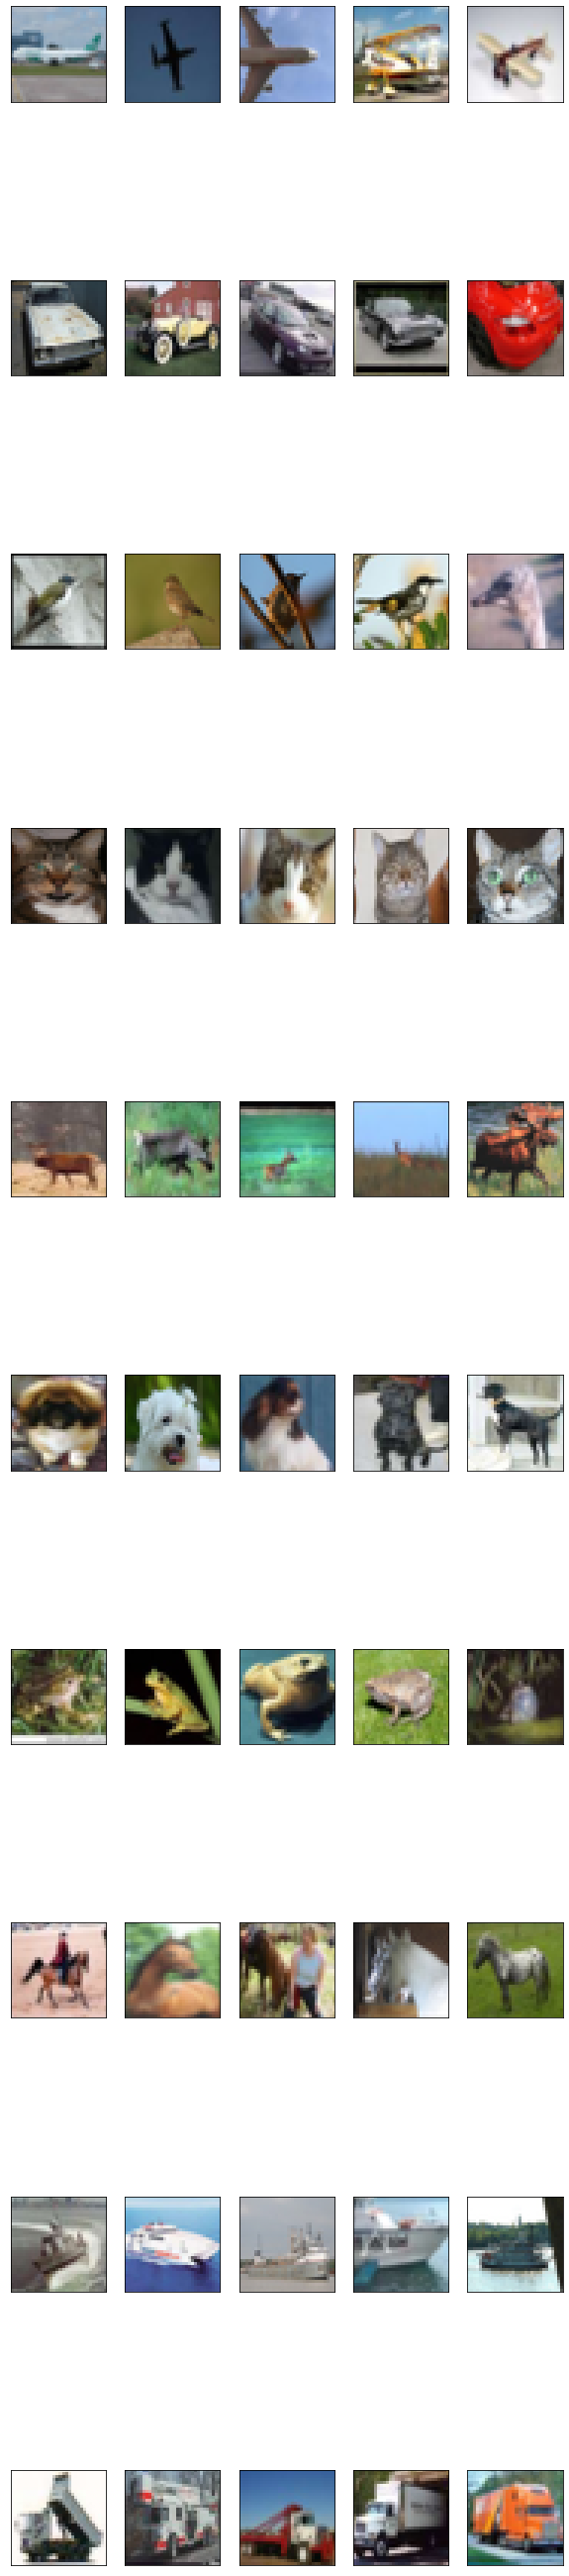

In [ ]:
number_of_samples = 5
plt.figure(figsize=(number_of_classes,number_of_samples*10))
image_shape = x_train.shape[1:]

c = 1
for i in range(number_of_classes):
    random_samples =  np.random.choice(np.argwhere(y_train == i)[:,0], number_of_samples)
    for j in range(number_of_samples):
        plt.subplot(number_of_classes,number_of_samples,c)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_train[random_samples[j]], cmap=plt.cm.binary)
        c += 1
plt.show()

## Fully-connected Neural Network

We often represent neural networks as a set of layers. Each layer has its own number of units, activation function, etc... For this example, we construct a very basic model consisting of only fully connected layers.

A fully connected layer (called `Dense` layer in TensorFlow and `Linear` in PyTorch) require a one-dimentional input. Hence, the first layer of our network only transforms the 2d image to a one-dimensional array. Resulting in an array of $height×width×channels=ArraySize$.

We have chosen 64 nodes (or units) for our first hidden fully connected layer. Increasing the number of nodes, increases complixity and computation time. Sometime it is more advantagous to increase complixity by increasing the number of layers rather than the number of nodes.

The last layer consist of 10-nodes that return an array of 10 probability scores that sums to 1. Each node contains a score that indicates the probability that the current image belongs to one of the 10 classes.

![alt text](https://miro.medium.com/max/844/1*Cc0LQodOm_vmYEm-DgTV8g.png)
[image source](https://towardsdatascience.com/coding-up-a-neural-network-classifier-from-scratch-977d235d8a24)

![alt text](https://svgshare.com/i/G7H.svg)



### PyTorch

#### Constants

In [5]:
BATCH_SIZE = 32
EPOCHS = 5

#### Dataset Loading from Keras

We can also import MNIST with PyTorch.

In [28]:
def normalize_data(x_train, y_train, flat=True):
    x_train = x_train / 255.
    if len(x_train.shape) < 4:
        x_train = x_train[..., None]
    x_train = x_train.transpose([0, 3, 1, 2])
    x_train = x_train.astype(np.float32)
    x_train = torch.from_numpy(x_train)
    if flat:
        x_train = torch.flatten(x_train, 1)
    y_train = y_train.astype(np.int64)
    return x_train, torch.from_numpy(y_train).view(-1)

#### Dataset

In [ ]:
from keras.datasets import mnist, cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=1)

x_train, y_train = normalize_data(x_train, y_train)
x_val, y_val = normalize_data(x_val, y_val)
x_test, y_test = normalize_data(x_test, y_test)
dataset = torch.utils.data.TensorDataset(x_train, y_train)
dataset = torch.utils.data.DataLoader(dataset, BATCH_SIZE)
val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
val_dataset = torch.utils.data.DataLoader(val_dataset)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
test_dataset = torch.utils.data.DataLoader(test_dataset)

#### Model Definition

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, input_size, number_of_classes=10):
        super(Net, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_size,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,number_of_classes)
        )

    def forward(self, x):
        return self.model(x)

model = Net(x_train.shape[1])
model.cuda()

Net(
  (model): Sequential(
    (0): Linear(in_features=3072, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)

#### Training Step

In [73]:
def train( model, train_loader, optimizer):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
    return loss.item(), correct / len(train_loader.dataset)

#### Testing/Evaluation Step

In [74]:
def test( model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += loss_fn(output, target).item() 
            pred = output.argmax(dim=1, keepdim=True)  
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    return test_loss,  correct / len(test_loader.dataset)

#### Loss Function

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

#### Optimizer

In [ ]:
optimizer = torch.optim.Adam(model.parameters())

#### Running the Training

In [ ]:
loss_history = []
acc_history = []
for i in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(model, dataset, optimizer)
    val_loss, val_acc = test(model, val_dataset)
    loss_history.append((train_loss, val_loss))
    acc_history.append((train_acc, val_acc))

100%|██████████| 5/5 [00:24<00:00,  4.93s/it]


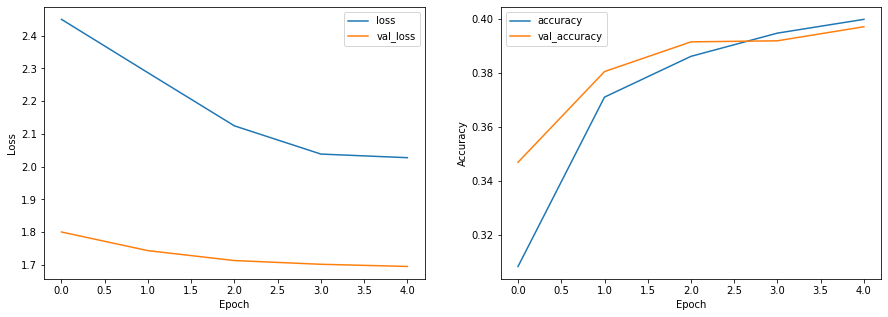

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
loss_history = np.array(loss_history)
acc_history = np.array(acc_history)
epochs_range = range(len(loss_history))

axs[0].plot(epochs_range, loss_history[:, 0])
axs[0].plot(epochs_range, loss_history[:, 1])
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend(['loss', 'val_loss'])

axs[1].plot(epochs_range, acc_history[:, 0])
axs[1].plot(epochs_range, acc_history[:, 1])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])

In [ ]:
loss, acc = test(model, test_dataset)
print(f"Test Dataset Loss: {loss}, Accuracy: {acc}")

Test Dataset Loss: 1.7069071883052587, Accuracy: 0.4016


### TensorFlow

#### Dataset Loading from Keras

In [ ]:
from keras.datasets import mnist, cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=1)

train_dataset = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (x_val, y_val)).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (x_test, y_test)).batch(BATCH_SIZE)

#### Model Definition

In [ ]:
class Net(keras.Model):
  def __init__(self, img_size, number_of_classes=10):
    super(Net, self).__init__()
    self.d1 = keras.layers.Dense(64, input_shape=[np.prod(img_size[1:])], activation='relu')
    self.d2 = keras.layers.Dense(number_of_classes, activation='softmax')
    self.flat = keras.layers.Flatten()

  def call(self, x):
    x = self.flat(x)
    x = self.d1(x)
    return self.d2(x)

model = Net(x_train.shape[1:])

#### Loss Function

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

#### Optimizer

In [ ]:
optimizer = tf.keras.optimizers.Adam()

#### Training Step

In [ ]:
@tf.function
def train_step(X, y):
  with tf.GradientTape() as tape:
    predictions = model(X)
    loss = loss_fn(y, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(y, predictions)

#### Test Step

In [ ]:
@tf.function
def test_step(X, y):
  predictions = model(X)
  t_loss = loss_fn(y, predictions)

  val_loss(t_loss)
  val_accuracy(y, predictions)

#### Training

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

loss_history = []
acc_history = []
for epoch in tqdm(range(EPOCHS)):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()

    for images, labels in train_dataset:
        train_step(images, labels)

    for val_images, val_labels in val_dataset:
        test_step(val_images, val_labels)

    loss_history.append((train_loss.result(), val_loss.result()))
    acc_history.append((train_accuracy.result(), val_accuracy.result()))

100%|██████████| 5/5 [00:19<00:00,  3.90s/it]


#### Testing/Evaluation Step

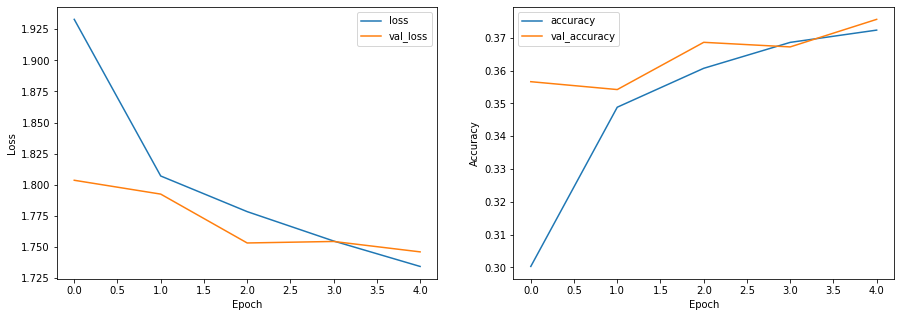

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
loss_history = np.array(loss_history)
acc_history = np.array(acc_history)
epochs_range = range(len(loss_history))

axs[0].plot(epochs_range, loss_history[:, 0])
axs[0].plot(epochs_range, loss_history[:, 1])
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend(['loss', 'val_loss'])

axs[1].plot(epochs_range, acc_history[:, 0])
axs[1].plot(epochs_range, acc_history[:, 1])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])

In [ ]:
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')
for X, y in test_dataset:
    predictions = model(X)
    test_accuracy(y, predictions)
print('\nTest accuracy:', test_accuracy.result().numpy())


Test accuracy: 0.3764


## Convolutional Neural Network

![alt text](https://miro.medium.com/max/1170/1*Fw-ehcNBR9byHtho-Rxbtw.gif)

### PyTorch

#### Repeated from Previous PyTorch Section 

In [79]:
from keras.datasets import mnist, cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=1)

x_train, y_train = normalize_data(x_train, y_train, flat=False)
x_val, y_val = normalize_data(x_val, y_val, flat=False)
x_test, y_test = normalize_data(x_test, y_test, flat=False)
dataset = torch.utils.data.TensorDataset(x_train, y_train)
dataset = torch.utils.data.DataLoader(dataset, BATCH_SIZE)
val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
val_dataset = torch.utils.data.DataLoader(val_dataset)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
test_dataset = torch.utils.data.DataLoader(test_dataset)

loss_fn = torch.nn.CrossEntropyLoss()

#### Model Definition


In [80]:
class Net(torch.nn.Module):
    def __init__(self, img_size, number_of_classes=10, model_width=32):
        super(Net, self).__init__()
        self.ConvLayers = torch.nn.Sequential(
            torch.nn.Conv2d(img_size[0], model_width, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(model_width, model_width*2, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )

        # self.ConvLayers = []

        # for i in range(model_depth):
        #     self.ConvLayers.append(
        #         torch.nn.Sequential(
        #             torch.nn.Conv2d(img_size[0], model_width, 3, padding=1),
        #             torch.nn.ReLU(),
        #             torch.nn.MaxPool2d(2),
        #         ) 
        #     )

        # self.ConvLayers = nn.Sequential(self.ConvLayers*)

        self.LinearLayers = torch.nn.Sequential(
            torch.nn.Linear(model_width*2, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, number_of_classes)
        )
        self.avgpooling = torch.nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.ConvLayers(x)

        x = self.avgpooling(x).flatten(1)

        return self.LinearLayers(x)

from torchvision.models import resnet18
model = resnet18(pretrained=True)
model.fc = torch.nn.Sequential(
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 10)
        )

# model = Net(x_train.shape[1:])
model.cuda()
optimizer = torch.optim.Adam(model.parameters())

#### Running the Training

In [81]:
loss_history = []
acc_history = []
for i in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(model, dataset, optimizer)
    val_loss, val_acc = test(model, val_dataset)
    loss_history.append((train_loss, val_loss))
    acc_history.append((train_acc, val_acc))

100%|██████████| 5/5 [09:56<00:00, 119.39s/it]


#### Testing/Evaluation Step

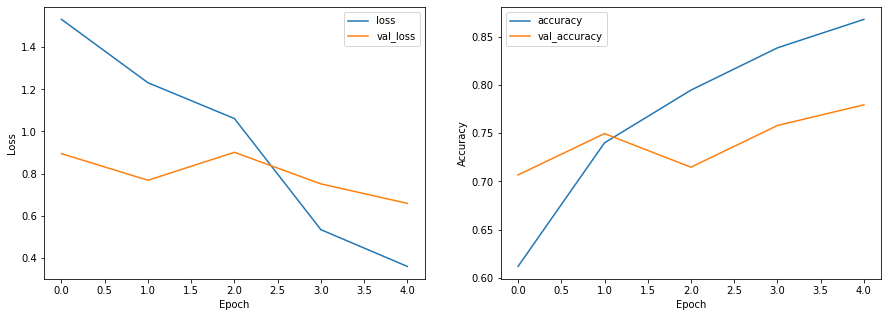

In [82]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
loss_history = np.array(loss_history)
acc_history = np.array(acc_history)
epochs_range = range(len(loss_history))
axs[0].plot(epochs_range, loss_history[:, 0])
axs[0].plot(epochs_range, loss_history[:, 1])
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend(['loss', 'val_loss'])

axs[1].plot(epochs_range, acc_history[:, 0])
axs[1].plot(epochs_range, acc_history[:, 1])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])

In [ ]:
loss, acc = test(model, test_dataset)
print(f"Test Dataset Loss: {loss}, Accuracy: {acc}")

### TensorFlow

#### Repeated from Previous TensorFlow Section 

In [58]:
from keras.datasets import mnist, cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=1)

if len(x_train.shape) < 4:
    x_train = x_train[..., tf.newaxis]
    x_test = x_test[..., tf.newaxis]
    x_val = x_val[..., tf.newaxis]

train_dataset = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (x_val, y_val)).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (x_test, y_test)).batch(BATCH_SIZE)


loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(X, y):
  with tf.GradientTape() as tape:
    predictions = model(X)
    loss = loss_fn(y, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(y, predictions)

@tf.function
def test_step(X, y):
  predictions = model(X)
  t_loss = loss_fn(y, predictions)

  val_loss(t_loss)
  val_accuracy(y, predictions)

#### Model Definition


In [69]:
class Net(keras.Model):
  def __init__(self, img_size, number_of_classes=10):
    super(Net, self).__init__()
    self.conv1 = keras.layers.Conv2D(16, 3, input_shape=img_size, activation='relu', padding='same')
    self.conv2 = keras.layers.Conv2D(32, 3, input_shape=img_size, activation='relu', padding='same')
    self.pool = keras.layers.MaxPool2D(2)
    self.flatten = keras.layers.Flatten()
    self.d1 = keras.layers.Dense(512, activation='relu')
    self.d2 = keras.layers.Dense(256, activation='relu')
    self.d3 = keras.layers.Dense(10, activation='softmax')

  def call(self, x):
    x = self.conv1(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.pool(x)
    x = self.flatten(x)
    x = self.d1(x)
    x = self.d2(x)
    return self.d3(x)

model = Net(x_train.shape[1:])


# base_model=applications.ResNet50(weights='imagenet',include_top=False, input_shape=(32, 32, 3)) #imports the mobilenet model and discards the last 1000 neuron layer.

# x=base_model.output
# x=keras.layers.Dense(2048,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
# x=keras.layers.Dense(1024,activation='relu')(x) #dense layer 2
# preds=keras.layers.Dense(10, activation='softmax')(x) #final layer with softmax activation

# model=keras.models.Model(inputs=base_model.input,outputs=preds)

# for layer in model.layers:
#     layer.trainable=True


#### Training

In [70]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

loss_history = []
acc_history = []
for epoch in tqdm(range(EPOCHS)):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()

    for images, labels in train_dataset:
        train_step(images, labels)

    for val_images, val_labels in val_dataset:
        test_step(val_images, val_labels)

    loss_history.append((train_loss.result(), val_loss.result()))
    acc_history.append((train_accuracy.result(), val_accuracy.result()))

100%|██████████| 1/1 [00:28<00:00, 28.45s/it]


#### Testing/Evaluation Step

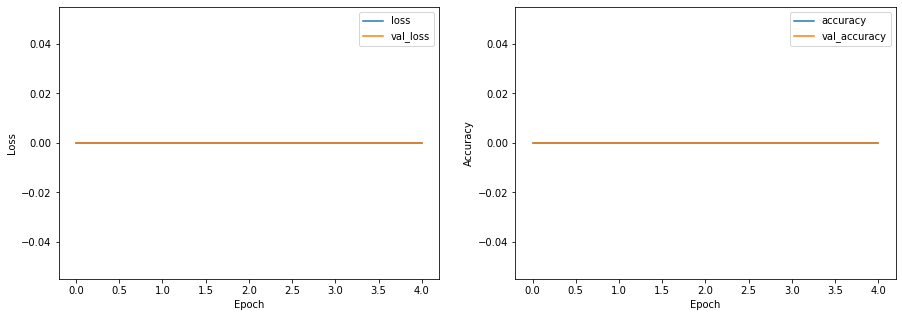

In [64]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
loss_history = np.array(loss_history)
acc_history = np.array(acc_history)
epochs_range = range(len(loss_history))

axs[0].plot(epochs_range, loss_history[:, 0])
axs[0].plot(epochs_range, loss_history[:, 1])
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend(['loss', 'val_loss'])

axs[1].plot(epochs_range, acc_history[:, 0])
axs[1].plot(epochs_range, acc_history[:, 1])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])

In [71]:
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')
for X, y in test_dataset:
    predictions = model(X)
    test_accuracy(y, predictions)
print('\nTest accuracy:', test_accuracy.result().numpy())


Test accuracy: 0.10497597


# Qualitative Analysis

In [19]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img.squeeze(), cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  plt.xlabel("{} {:2.0f}% ".format('Highest Probability', 100*np.max(predictions_array)), color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
#   print(type(true_label))
  if not isinstance(true_label, int):
      thisplot[true_label.item()].set_color('blue')
  else:
      thisplot[true_label].set_color('blue')
  cmap = plt.cm.coolwarm
  custom_lines = [Line2D([0], [0], color=cmap(0.), lw=4),
                Line2D([0], [0], color=cmap(.5), lw=4),
                Line2D([0], [0], color=cmap(1.), lw=4)]
  plt.legend(custom_lines, ['True Label', 'Other Labels', 'Predicted Label'])

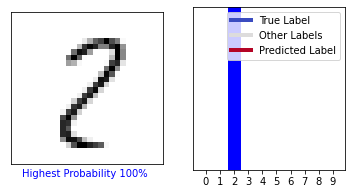

In [26]:
predictions = model.predict(x_test)
i = np.random.randint(0, y_test.shape[0])
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()